In [ ]:
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
data_path = '/content/drive/MyDrive/dataset-resized'

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [ ]:
import tensorflow as tf
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def extract_features(generator):
    features = model.predict(generator)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(train_generator)
val_features, val_labels = extract_features(validation_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 635s 10s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 178s 12s/step


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='auto'))

svm_model.fit(train_features, train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [ ]:
val_predictions = svm_model.predict(val_features)

from sklearn.metrics import classification_report
class_labels = list(validation_generator.class_indices.keys())
print(classification_report(val_labels, val_predictions, target_names=class_labels))

              precision    recall  f1-score   support

   cardboard       0.95      0.65      0.77        80
       glass       0.67      0.80      0.73       100
       metal       0.76      0.80      0.78        82
       paper       0.71      0.92      0.80       118
     plastic       0.73      0.57      0.64        96
       trash       0.62      0.30      0.40        27

    accuracy                           0.74       503
   macro avg       0.74      0.67      0.69       503
weighted avg       0.75      0.74      0.73       503



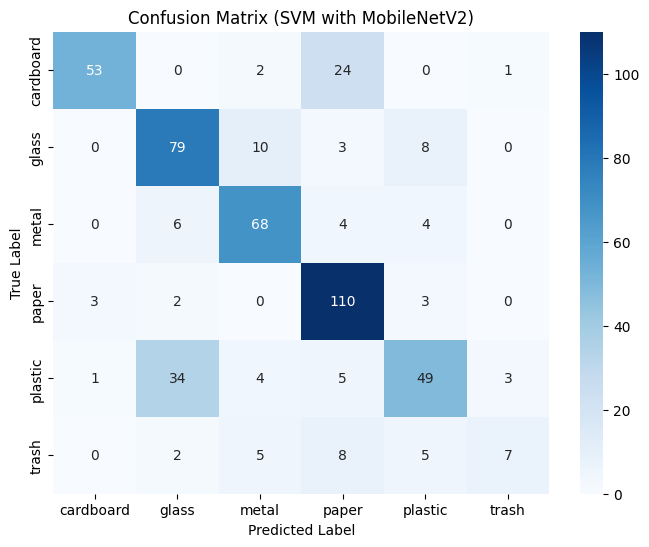

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SVM with MobileNetV2)")
plt.show()

In [ ]:
val_predictions = svm_model.predict(val_features)

In [ ]:
from sklearn.metrics import accuracy_score

svm_accuracy = accuracy_score(val_labels, val_predictions)
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")

SVM Accuracy: 72.76%


In [ ]:
support_vectors_per_class = svm_model.named_steps['svc'].n_support_
total_support_vectors = svm_model.named_steps['svc'].support_vectors_.shape[0]

print(f"Support Vectors per Class: {support_vectors_per_class}")
print(f"Total Support Vectors: {total_support_vectors}")

Support Vectors per Class: [229 347 297 387 322 110]
Total Support Vectors: 1692


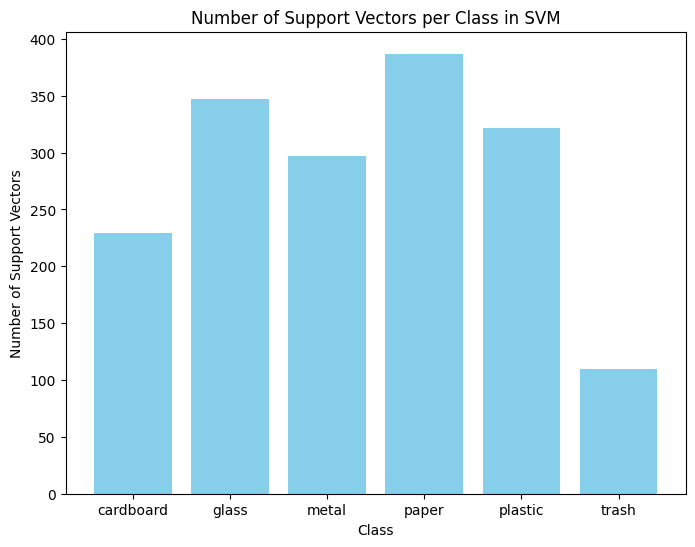

In [ ]:
import matplotlib.pyplot as plt

class_labels = list(validation_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
plt.bar(class_labels, support_vectors_per_class, color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Support Vectors")
plt.title("Number of Support Vectors per Class in SVM")
plt.show()

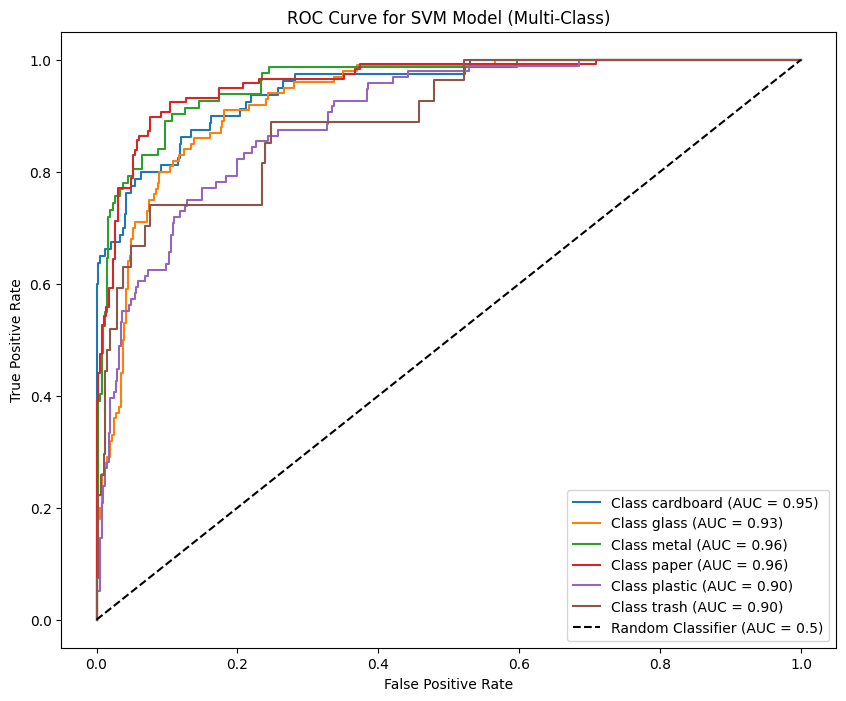

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

val_labels_binarized = label_binarize(val_labels, classes=np.arange(len(class_labels)))
val_decision_scores = svm_model.decision_function(val_features)

plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(val_labels_binarized[:, i], val_decision_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for SVM Model (Multi-Class)")
plt.legend(loc="best")
plt.show()